# <center> 🚀SPACESHIP TITANIC -📊EDA + 27 DIFFERENT MODELS📈 </center>

## lazypredict
- 머신러닝 자동화 오픈소스
- 여러 ML 모델 불러올 수 있음
- 파라미터 조정 불가능

In [15]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas #Upgrading pandas

clear_output()

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')


In [17]:
train = pd.read_csv("../input/spaceship-titanic/train.csv")
test = pd.read_csv("../input/spaceship-titanic/test.csv")
submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")

RANDOM_STATE = 12 
FOLDS = 5
STRATEGY = 'median'

## <span style="color:#e76f51;"> Column Descriptions  : </span>


- `PassengerId` - 각 승객의 고유한 ID
                  - gggg : 같이 가는 그룹
                  - pp : 그룹 안의 번호

- `HomePlanet` - 출발지

- `CryoSleep` - 여행 중 승객이 동면상태에 드는 여부

- `Cabin` - 머무는 객실

- `Destination` - 목적지

- `Age` - 나이

- `VIP` - VIP

- `RoomService`, FoodCourt, ShoppingMall, Spa, VRDeck - 승객이 우주선에서 지불해야할 금액

- `Name` - 처음, 끝 이름

- `Transported` - 다른 차원으로 이동되었는지


<a id="3.1"></a>
## <span style="color:#e76f51;"> 1. Train Data  </span>

### (1) 행

In [18]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [19]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


`행` - 8693개
`열` - 14개
`데이터` - 119378개
`결측값` - 2324개

### (2) 열의 결측값

In [20]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False))


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


### (3) Train 데이터의 통계

In [21]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


<a id="3.2"></a>
## <span style="color:#e76f51;"> 2. Test Data </span> 

### (1) 행

In [22]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez


In [23]:
print(f'\033[94mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[94mNumber of values in train data: {test.count().sum()}')
print(f'\033[94mNo of rows with missing values  in test data: {sum(test.isna().sum())}')

Number of rows in test data: 4277
Number of columns in test data: 13
Number of values in train data: 54484
No of rows with missing values  in test data: 1117


`행` - 4277개
`열` - 13개
`데이터` - 54484개
`결측값` - 1117개

### (2) 열의 결측값

In [24]:
print(f'\033[94m')
print((test.isna().sum().sort_values(ascending = False)))


FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


### (3) Test 데이터의 통계

In [25]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


<a id="3.3"></a>
## <span style="color:#e76f51;"> 3. Submission File : </span>

### 행
**> 승객 ID , 도착지가 중요**

In [26]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


<a id="4"></a>
# **<center><span style="color:#00BFC4;"> EDA </span></center>**

<a id="4.1"></a>
## <span style="color:#e76f51;"> 데이터 분석 </span>

In [27]:
train.drop(["PassengerId"] , axis = 1 , inplace = True)
test.drop(["PassengerId"] , axis = 1 , inplace = True)
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12 

In [28]:
train.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

ImportError: cannot import name 'AxisInt' from 'pandas._typing' (/opt/conda/lib/python3.10/site-packages/pandas/_typing.py)

<a id="4.7"></a>
## <span style="color:#e76f51;"> (1) 분포 - 결측값   </span>

<a id="4.2.1"></a>
### <span style="color:#e76f51;">(1) 행 </span>

In [30]:
# TEST 
test_null = pd.DataFrame(test.isna().sum()) #결측값 확인
test_null = test_null.sort_values(by = 0 ,ascending = False) # 내림차순으로 정렬

# TRAIN 
train_null = pd.DataFrame(train.isna().sum()) #결측값 확인
train_null = train_null.sort_values(by = 0 ,ascending = False)[:-1] # 내림차순으로 정렬


# 그래프 생성
fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values")

fig.add_trace(go.Bar(x=train_null[0],
                     y=train_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)' , 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=test_null[0], 
                     y=test_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)', 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 2)

fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x=0.5)

<a id="4.7.2"></a>
### <span style="color:#e76f51;">(2) 열</span>

In [31]:
# TRAIN 결측값 합
missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()

# TEST 결측값 합
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()


missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values",)

fig.add_trace(go.Bar(x=missing_train_row["no"], 
                     y=missing_train_row["count"]  ,
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)' ,
                                line_width = 3
                                ,coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x= missing_test_row["no"], 
                     y=missing_test_row["count"],
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)',
                                line_width = 3 ,
                                coloraxis="coloraxis")),
              1, 2)
fig.update_layout(showlegend=False, title_text="Row wise Null Value Distribution", title_x=0.5)

<a id="4.2"></a>
## <span style="color:#e76f51;"> 분포 - Continuos, Categorical Data </span>

In [32]:
# train, test featrue 결합
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)

text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features ]

del df
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')
print(f'\033[94mNumber of text features: {len(text_features)}')


# 라벨링 후 그래프 생성
# (1) Categorical - 텍스트 X인 25미만의 고유값
# (2) Continuous - 텍트스 X인 25이상의 고유값
# (3) Text - 텍스트 형식의 데이터, Cabin, Name
labels=['Categorical', 'Continuos', "Text"]
values= [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

# 그래프로 생성
fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, pull=[0.1, 0, 0 ],
    marker=dict(colors=colors, 
                line=dict(color='#000000', 
                          width=2))
)])
fig.show()

Total number of features: 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


<a id="4.3"></a>
## <span style="color:#e76f51;"> 1. 분포 - Continous Features </span>

### <span style="color:#e76f51;">  나이 분포 </span>



In [33]:
# train, test의 나이 
train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"

# 둘의 값 합 - 히스토그램으로 출력
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf, 
                   x="Age",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Age" , title_x = 0.5)
fig.show()

<a id="4.4"></a>
## <span style="color:#e76f51;">  2. 분포 - Categorical Features </span>

ValueError: could not convert string to float: 'Europa'

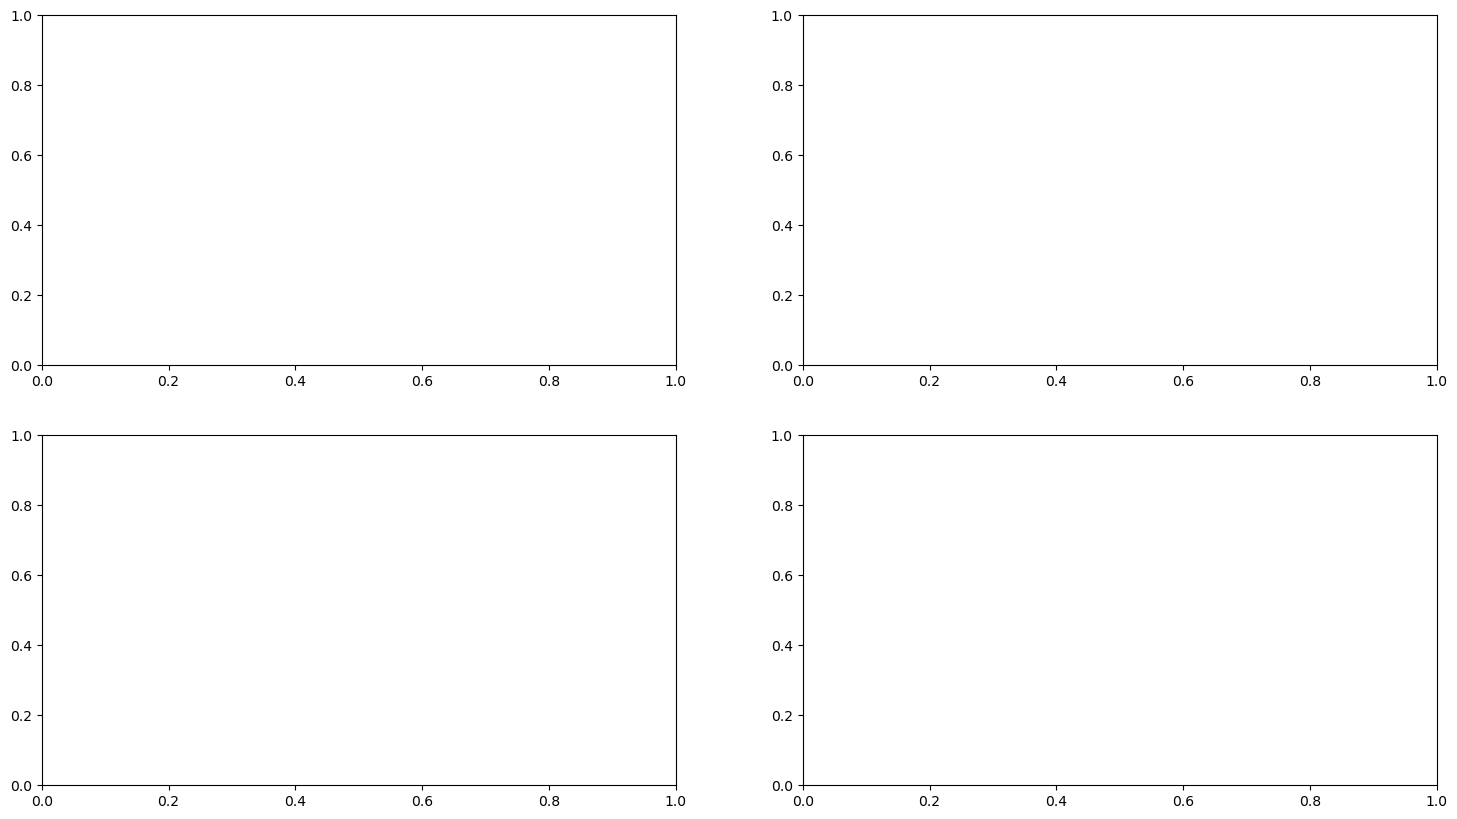

In [34]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 2
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train[col],ax = axes[r,c] ,palette = "viridis", label='Train data')
            sns.countplot(test[col],ax = axes[r,c] ,palette = "magma", label='Test data')
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=20)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4.5"></a>
## <span style="color:#e76f51;"> 3. 분포 - Target (도착) </span>

In [35]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df, 
             x = TARGET,
             y = 'count'
            ) 
fig.update_traces(marker_color =['#58D68D','#DE3163'], 
                  marker_line_color='rgb(0,0,0)',
                  marker_line_width=2,)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]* 100 / train.shape[0]))
fig.show()

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 49.64 %


<a id="4.6"></a>
## <span style="color:#e76f51;"> 상관관계 </span>

In [ ]:
fig = px.imshow(train.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.show()

<a id="5"></a>
## <span style="color:#e76f51;"> 데이터 전처리 </span>

In [36]:
# 전처리 행 - 나이, 이용서비스(푸드코트, 쇼핑몰, 스파, VR, 룸서비스)
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "RoomService"]

# 사이킷런 - SimpleImputer .. Nan 값을 채우기 위함
imputer = SimpleImputer(strategy = STRATEGY)
imputer.fit(train[imputer_cols])

# DataFrame 생성 
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])

# fillna - 결측값 변경
train["HomePlanet"].fillna('Z', inplace=True)
test["HomePlanet"].fillna('Z', inplace=True)

In [37]:
label_cols = ["HomePlanet", "CryoSleep","Cabin", "Destination" ,"VIP"]
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train ,test = label_encoder(train,test ,label_cols)

In [38]:
train.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
test.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

<a id="6"></a>
# **<center><span style="color:#00BFC4;">Modeling </span></center>**

<a id="6.1"></a>
## <span style="color:#e76f51;"> (1) 27개 분류 모델 확인( LAZY PREDICT ) : </span>

LazyClassifier 모델에서 상세 설명은 불러오지 않고, 모든 분류모델을 불러온다

In [39]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers='all')

models, predictions = clf.fit(X_train , X_test , y_train , y_test)
clear_output()

**모델 15개 다음 사항을 확인**

Accuracy : 정확도

Balanced Accuracy : 불균형 데이터 셋의 과장된 성능 추정을 방지

Roc Auc : 임계값에서 모델의 분류 성능

F1 Score : 정밀도

Time Taken : 소요시간

In [40]:
models[:15]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.79,0.79,0.79,0.79,0.77
XGBClassifier,0.78,0.78,0.78,0.78,0.41
AdaBoostClassifier,0.77,0.77,0.77,0.77,0.36
RandomForestClassifier,0.77,0.77,0.77,0.77,1.05
NuSVC,0.77,0.77,0.77,0.77,2.05
LogisticRegression,0.77,0.77,0.77,0.77,0.07
SVC,0.77,0.77,0.77,0.77,1.70
ExtraTreesClassifier,0.76,0.76,0.76,0.76,0.87
LinearSVC,0.76,0.76,0.76,0.76,0.48


<a id="6.1"></a>
## <span style="color:#e76f51;"> (2) 성능 시각화  </span>

1. 모델별 정확성

In [41]:
line = px.line(data_frame= models ,y =["Accuracy"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

2. 모델별 ROC AUC, F1 Score

In [42]:
line = px.line(data_frame= models ,y =["ROC AUC" , "F1 Score"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "ROC AUC SCORE")
line.update_layout(showlegend = True,
    title = {
        'text': 'ROC AUC and F1 Score vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

3. 모델별 소요시간

In [43]:
line = px.line(data_frame= models ,y =["Time Taken"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Time(s)")
line.update_traces(line_color="purple")
line.update_layout(showlegend = True,
    title = {
        'text': 'TIME TAKEN vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

<a id="6.2"></a>
## <span style="color:#e76f51;"> (3) LGBM Classifier(5 FOLDS)  : </span>

--- 

### k겹 교차 검증 (K-Fold)
Train, Test Set을 나눠 K번 반복하여 모델을 학습시킨 것

In [46]:
lgb_params = {
    'objective' : 'binary',
    'n_estimators' :50,
    'learning_rate' : 0.08
}

lgb_predictions = 0
lgb_scores = []
lgb_fimp = []
LGBM_FEATURES = list(train.columns)[:-1]
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_FEATURES], train[TARGET])):
    print(f'\033[94m')
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][LGBM_FEATURES], train.iloc[valid_idx][LGBM_FEATURES]
    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid,  preds_valid)
    lgb_scores.append(acc)
    run_time = time.time() - start_time
    
    fim = pd.DataFrame(index=LGBM_FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    
    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%, Run Time: {run_time:.2f}s")
    test_preds = model.predict(test[LGBM_FEATURES]) 
    lgb_predictions += test_preds/FOLDS
print("")
print("Mean Accuracy :", np.mean(lgb_scores))


========== Fold=1 ==========
Fold=1, Accuracy score: 0.81%, Run Time: 0.77s

========== Fold=2 ==========
Fold=2, Accuracy score: 0.78%, Run Time: 0.95s

========== Fold=3 ==========
Fold=3, Accuracy score: 0.79%, Run Time: 0.41s

========== Fold=4 ==========
Fold=4, Accuracy score: 0.79%, Run Time: 0.49s

========== Fold=5 ==========
Fold=5, Accuracy score: 0.81%, Run Time: 0.41s

Mean Accuracy : 0.7958136330880743


### <span style="color:#e76f51;">(4) 항목 별 중요도 </span>

In [ ]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Feature Importance Across Folds')
plt.show()

<a id="7"></a>
# **<center><span style="color:#00BFC4;">Submission </span></center>**

In [50]:
submission[TARGET] = lgb_predictions.astype("bool")
submission.to_csv("submission.csv",index=False)
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
